In [4]:
import random
import csv
from random import randint
from datetime import datetime, timedelta, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
phase_list = [" L1", " L2", " L3"]

voltage = "Spänning"

active_power_consumption = "P14"

active_energy_consumption = "A14"

reactive_power_consumption = "Q12"

reactive_energy_consumption = "R12"

active_power_production = "P23"

active_energy_production = "A23"

reactive_power_production = "Q34"

reactive_energy_production = "R34"

In [6]:
fieldnames = [
    "series_id",
    "location_id",
    "meter_id",
    "time",
    "value",
    "value_status",
    "insert_time",
    "extract_time",
]

In [7]:
# [(location id,meter id)]
def generate_lid_mid(isRandom, size):
    if isRandom:

        return [
            (
                "".join(["{}".format(random.randint(0, 9)) for _ in range(18)]),
                "".join(["{}".format(random.randint(0, 9)) for _ in range(16)]),
            )
            for _ in range(size)
        ]
    else:
        return [
            (
                random.randint(800000000000000000, 900000000000000000),
                random.randint(6000000000000000, 7000000000000000),
            )
            for _ in range(size)
        ]

In [8]:
# total iteration that will run
# in total 19 * 10 * total_event (19 series id, 10 meter-location ids)
# series id can vary based on day or nigh (consumption or production)
total_event = 10000

# start deviation after 100 iteration
deviation_start = 1000
# time each deviation occurs
voltage_dev = 3
power_zero_dev = 3
voltage_alt = 1
voltage_phase_zero = 1
# there will be deviation_time times a deviation will occur
deviation_time = power_zero_dev + voltage_dev + voltage_alt + voltage_phase_zero

# the deviation duration in iteration
deviation_duration_count = 500
# offset so that two deviation iteration are not side by side
offset = 0

if (deviation_duration_count * deviation_time > total_event) or (
    deviation_duration_count > total_event
):
    raise Exception("cannot have more deviation than total events")

# randomly generate meter id and location id
is_mid_lid_random = False
# size of  meter and location ids
size_mid_lid = 10
# fault meters
faulty_meters_count = 4

# output file path
file_path = "data/generated_event.csv"

if faulty_meters_count > size_mid_lid:
    raise Exception("cannot have more faulty meters than total meters")

lid_mid = generate_lid_mid(is_mid_lid_random, size_mid_lid)
fault_meters = sorted(random.sample(lid_mid, faulty_meters_count))

# day start at 9 and end at 17
day_start = 8
day_end = 17

possible_values = list(
    range(
        deviation_start,
        total_event - deviation_duration_count,
        deviation_duration_count + offset,
    )
)
# deviation iteration value on when to trigger a deviation
deviation_points = sorted(random.sample(possible_values, deviation_time))

In [9]:
print(f"total event to generate {total_event}")
print(f"single deviation size in iteration {deviation_duration_count}")
print(f"total deviation size in iteration {deviation_duration_count * deviation_time}")
print(f"day start {day_start}")
print(f"day end {day_end}")
print(f"deviation starting points {deviation_points}")
print(f"fault meters {fault_meters}")

total event to generate 10000
single deviation size in iteration 500
total deviation size in iteration 4000
day start 8
day end 17
deviation starting points [1000, 1500, 4000, 5500, 6500, 7000, 7500, 8500]
fault meters [(800321385908627682, 6495802207935338), (860152803710272173, 6608999952681631), (888052871650998857, 6145600380398824), (894291538338273756, 6326269688502575)]


In [10]:
def get_value(sid, val_type):
    ret_val: int
    if sid.startswith("Spänning"):
        match (val_type):
            case "voltage-high":
                ret_val = round(random.uniform(241, 246), 0)
            case "voltage-low":
                ret_val = round(random.uniform(229, 234), 0)
            case "voltage-zero" | "p-zero":
                ret_val = 0.0
            case _ if (val_type == "l1" and sid == "Spänning L1"):
                ret_val = 0.0
            case _ if val_type == "l2" and sid == "Spänning L2":
                ret_val = 0.0
            case _ if val_type == "l3" and sid == "Spänning L3":
                ret_val = 0.0
            case _:
                ret_val = round(random.uniform(235, 240), 0)
    elif sid.startswith("P14"):  # active-power-consumption/kW
        match (val_type):
            case "power-high":
                ret_val = round(random.uniform(2, 3), 3)
            case "power-low":
                ret_val = round(random.uniform(0.01, 1), 3)
            case "power-zero" | "p-zero":
                ret_val = 0.0
            # case "P14 L1" | "P14 L2" | "P14 L3":
            case _:
                ret_val = round(random.uniform(1, 2), 3)
    elif sid.startswith("P23"):  # active-power-production/kW
        match (val_type):
            case "power-high":
                ret_val = round(random.uniform(2, 3), 3)
            case "power-low":
                ret_val = round(random.uniform(0.01, 1), 3)
            case "power-zero" | "p-zero":
                ret_val = 0.0
            # case "P23 L1" | "P23 L2" | "P23 L3":
            case _:
                ret_val = round(random.uniform(1, 2), 3)
    elif sid.startswith("A14"):  # active-energy-consumption/kWh
        match (val_type):
            case "energy-high":
                ret_val = round(random.uniform(16, 19), 3)
            case "energy-low":
                ret_val = round(random.uniform(5, 8), 3)
            case "energy-zero" | "p-zero":
                ret_val = 0.0
            case _:
                ret_val = round(random.uniform(14, 16), 3)
    elif sid.startswith("A23"):  # active-energy-production/kWh
        match (val_type):
            case "energy-high":
                ret_val = round(random.uniform(16, 19), 3)
            case "energy-low":
                ret_val = round(random.uniform(5, 8), 3)
            case "energy-zero" | "p-zero":
                ret_val = 0.0
            case _:
                ret_val = round(random.uniform(14, 16), 3)
    elif sid.startswith("Q12"):  # reactive-power-consumption/kVAr
        match (val_type):
            case "power-high":
                ret_val = round(random.uniform(2, 3), 3)
            case "power-low":
                ret_val = round(random.uniform(0.01, 1), 3)
            case "power-zero" | "p-zero":
                ret_val = 0.0
            # case "Q12 L1" | "Q12 L2" | "Q12 L3":
            case _:
                ret_val = round(random.uniform(1, 2), 3)
    elif sid.startswith("Q34"):  # reactive-power-production/kVAr
        match (val_type):
            case "power-high":
                ret_val = round(random.uniform(2, 3), 3)
            case "power-low":
                ret_val = round(random.uniform(0.01, 1), 3)
            case "power-zero" | "p-zero":
                ret_val = 0.0
            # case "Q34 L1" | "Q34 L2" | "Q34 L3":
            case _:
                ret_val = round(random.uniform(1, 2), 3)
    elif sid.startswith("R12"):  # reactive-energy-consumption/kVArh
        match (val_type):
            case "energy-high":
                ret_val = round(random.uniform(16, 19), 3)
            case "energy-low":
                ret_val = round(random.uniform(5, 8), 3)
            case "energy-zero" | "p-zero":
                ret_val = 0.0
            case _:
                ret_val = round(random.uniform(14, 16), 3)
    elif sid.startswith("R34"):  # reactive-energy-production/kVArh
        match (val_type):
            case "energy-high":
                ret_val = round(random.uniform(16, 19), 3)
            case "energy-low":
                ret_val = round(random.uniform(5, 8), 3)
            case "energy-zero" | "p-zero":
                ret_val = 0.0
            case _:
                ret_val = round(random.uniform(14, 16), 3)
    else:
        print("unknow series id")
    return ret_val

In [11]:
def is_day_night(timestamp):
    start = time(day_start)
    end = time(day_end)

    return start <= timestamp <= end

In [12]:
def random_event_type_generator(isDay):
    tup = set()

    tup.add(voltage + phase_list[0])
    tup.add(voltage + phase_list[1])
    tup.add(voltage + phase_list[2])

    if isDay:
        tup.add(active_power_consumption + phase_list[0])
        tup.add(active_power_consumption + phase_list[1])
        tup.add(active_power_consumption + phase_list[2])

        tup.add(reactive_power_consumption + phase_list[0])
        tup.add(reactive_power_consumption + phase_list[1])
        tup.add(reactive_power_consumption + phase_list[2])

        tup.add(active_energy_consumption)
        tup.add(reactive_energy_consumption)

    else:
        tup.add(active_power_production + phase_list[0])
        tup.add(active_power_production + phase_list[1])
        tup.add(active_power_production + phase_list[2])

        tup.add(reactive_power_production + phase_list[0])
        tup.add(reactive_power_production + phase_list[1])
        tup.add(reactive_power_production + phase_list[2])

        tup.add(active_energy_production)
        tup.add(reactive_energy_production)

    return tup

In [13]:
def generate_event(time, dev_type, is_day):
    for lid, mid in lid_mid:

        if not (any(int(x[1]) == int(mid) for x in fault_meters)):
            dev_type_pass = "norm"
        else:
            dev_type_pass = dev_type

        for x in random_event_type_generator(is_day):

            yield {
                "series_id": x,
                "location_id": lid,
                "meter_id": mid,
                "time": time,
                "value": get_value(x, dev_type_pass),
                "value_status": "Correct",
                "insert_time": time,
                "extract_time": time,
            }

In [14]:
def generate_readings(
    start_time, total_event, voltage_dev, power_zero_dev, voltage_alt, voltage_phase_zero
):
    current_time = start_time
    with open(file_path, mode="w", newline="", encoding="utf8") as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        dev_count = 0
        dev_type = "norm"
        main_dev_mode = "none"
        tmp_var = "none"
        for itr in range(total_event):
            is_day: bool
            if is_day_night(current_time.time()):
                is_day = True
            else:
                is_day = False

            if itr in deviation_points:
                if voltage_dev != 0:
                    voltage_dev -= 1
                    if random.choice((True, False)):
                        dev_type = "voltage-high"
                    else:
                        dev_type = "voltage-low"
                elif power_zero_dev != 0:
                    power_zero_dev -= 1
                    main_dev_mode = "power-zero"
                elif voltage_alt != 0:
                    voltage_alt -= 1
                    main_dev_mode = "voltage-alt"
                elif voltage_phase_zero != 0:
                    voltage_phase_zero -= 1
                    ch = random.choice(("l1", "l2", "l3"))
                    if tmp_var == "l1":
                        dev_type = "l2"
                    elif tmp_var == "l2":
                        dev_type = "l3"
                    else:
                        dev_type = "l1"
                    tmp_var = ch

            if main_dev_mode == "voltage-alt":
                if dev_type == "voltage-zero":
                    dev_type = "voltage-low"
                else:
                    dev_type = "voltage-zero"
            elif main_dev_mode == "power-zero":
                dev_type = "p-zero"

            event_gen = generate_event(
                current_time,
                dev_type,
                is_day,
            )

            if dev_type != "norm":
                dev_count += 1
                if dev_count == deviation_duration_count:

                    dev_type = "norm"
                    main_dev_mode = "none"

                    dev_count = 0
            # series id multplied by unique meters ids
            # voltage * 3 +
            # (P14 * 3 + Q12 * 3 + A14 + R12) +
            # (P23 * 3 + Q34 * 3 + A23 + R34)
            v = (3 + 3 + 3 + 1 + 1) * size_mid_lid
            for _ in range(v):
                event = next(event_gen)
                writer.writerow(event)
            current_time += timedelta(minutes=15)

In [15]:
# User-defined start time
start_time_str = "2023-01-15 08:00:00.1"
start_time = datetime.strptime(start_time_str, "%Y-%m-%d %H:%M:%S.%f")

# Generate readings
generate_readings(
    start_time, total_event, voltage_dev, power_zero_dev, voltage_alt, voltage_phase_zero
)

# print(start_time.time())

In [16]:
def plot_single_axis(selected_series_id, selected_location_id):
    chunk_size = 10000
    time_data, value_data = [], []

    # with milliseconds
    # .strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]

    dateparse = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")
    # , parse_dates=["time"], date_parser=dateparse

    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        filtered_chunk = chunk[
            (selected_series_id == chunk["series_id"])
            & (selected_location_id == chunk["location_id"])
        ]

        time_data.extend(filtered_chunk["time"])
        value_data.extend(filtered_chunk["value"])

    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(
        time_data,
        value_data,
        marker="o",
        linestyle="-",
        markersize=3,
        color="b",
        alpha=0.7,
    )

    # Formatting the plot
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(
        f"Plot of 'Value' Over 'Time' (Series ID: {selected_series_id}, Location ID: {selected_location_id})"
    )
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

In [17]:
def plot_dual_axis(selected_series_ids, selected_location_id, file_path):
    chunk_size = 10000
    time_series_data = {
        series_id: {"time": [], "value": []} for series_id in selected_series_ids
    }

    # Initialize storage for each series ID
    for series_id in selected_series_ids:
        time_series_data[series_id] = {"time": [], "value": []}

    # Read CSV in chunks
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        filtered_chunk = chunk[chunk["location_id"] == selected_location_id]

        for series_id in selected_series_ids:
            series_data = filtered_chunk[filtered_chunk["series_id"] == series_id]
            time_series_data[series_id]["time"].extend(series_data["time"])
            time_series_data[series_id]["value"].extend(series_data["value"])

    fig, ax1 = plt.subplots(figsize=(12, 6))

    #1st axis
    colors_one = ["tab:red","tab:blue","tab:green"]
    ax1.set_xlabel("Time")
    ax1.set_ylabel(f"Value Voltages", color=colors_one[0])
    ax1.tick_params(axis="y", labelcolor=colors_one[0])
    for i, series_id_one in enumerate(selected_series_ids[:3]):
        color = colors_one[i % len(colors_one)]
        ax1.plot(
            time_series_data[series_id_one]["time"],
            time_series_data[series_id_one]["value"],
            color=color,
            label=f"Series {series_id_one}",
        )
        
    # 2nd axis
    colors_two = ["tab:orange", "tab:purple"]
    ax2 = ax1.twinx()
    ax2.set_ylabel(f"Value Power", color=colors_two[0])
    ax2.tick_params(axis="y", labelcolor=colors_two[0])
    for i, series_id_two in enumerate(selected_series_ids[3:]):
        color = colors_two[i % len(colors_two)]
        ax2.plot(
            time_series_data[series_id_two]["time"],
            time_series_data[series_id_two]["value"],
            color=color,
            label=f"Series {series_id_two}",
        )

    ax1.legend()
    ax2.legend()
    fig.tight_layout()
    plt.show()

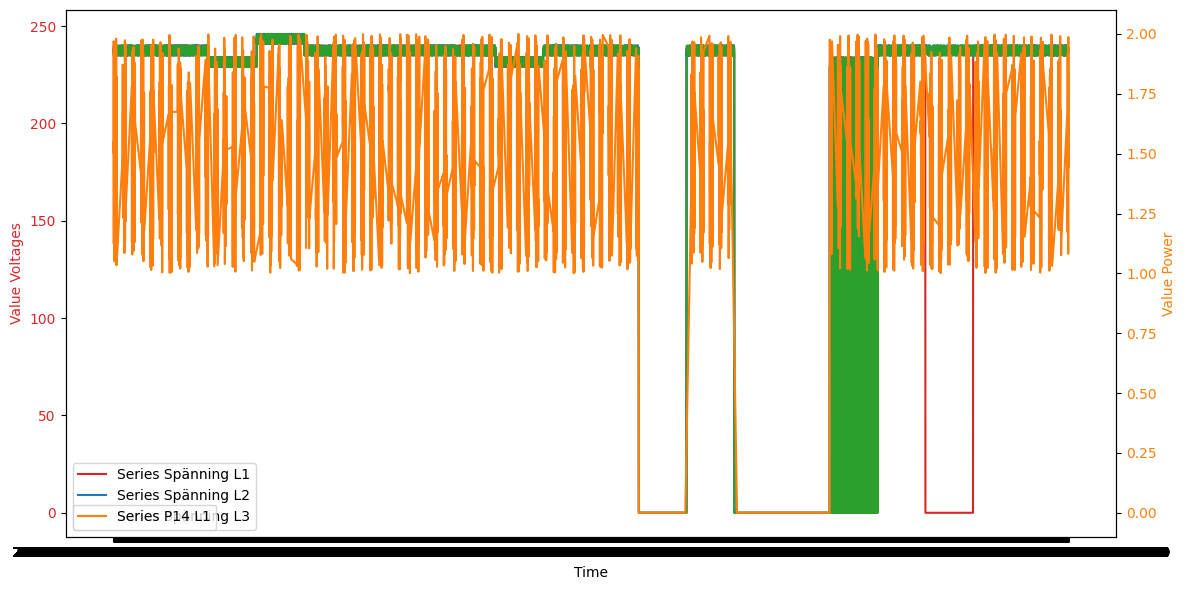

In [18]:
selected_series_ids = ["Spänning L1", "Spänning L2", "Spänning L3","P14 L1"]
target_location_id = fault_meters[0][0]
file_path = "data/generated_event.csv"
plot_dual_axis(selected_series_ids, target_location_id, file_path)